<a href="https://colab.research.google.com/github/satendra-p/book_recommendation_system_/blob/main/Book_Recommendation_System_Unsupervised_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Title: Book Recommendation System
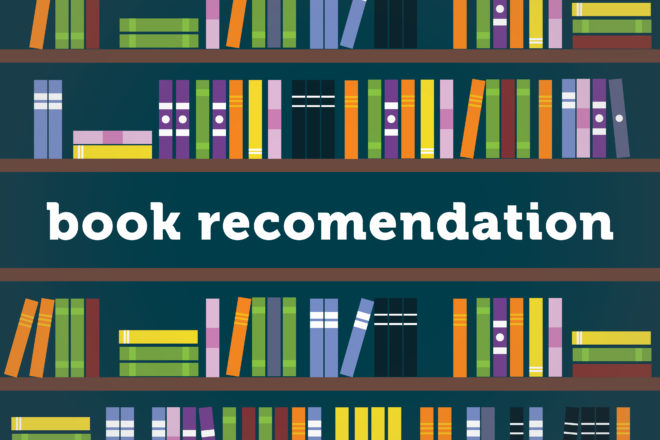

#Problem Statement

During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.

In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).

Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

Personal recommendation systems have been emerged to conduct effective search which related booksbased on user rating and interest.The proposed system used the K-NN Cosine Distance function to measure distance and Cosine Similarity function to find Similarity between the book clusters also we implemented SVD system that give us good recommandation.

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
#Importing modules
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings("ignore")


#The Data
The Book-Crossing dataset comprises 3 files.

**● Users :**

Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

**● Books :**

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

**● Ratings :**

Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [91]:
books = pd.read_csv('/content/drive/MyDrive/Unsupervised_ML_book_recommendation/Books.csv')
users = pd.read_csv('/content/drive/MyDrive/Unsupervised_ML_book_recommendation/Users.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Unsupervised_ML_book_recommendation/Ratings.csv')


In [92]:
#printing the shape of all three data sets
print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


#Pre-processing


Books Dataset Pre-processing

In [93]:
#Printing Top 5 rows
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [94]:
## Drop URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [95]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [96]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing


In [97]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [98]:
#filling null values with others
books.at[187689 ,'Book-Author'] = 'Other'
books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [99]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [100]:
#making this setting to display full text in columns
pd.set_option('display.max_colwidth', None)


In [101]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [102]:
#Checking the rows having 'DK Publishing Inc' and 'Gallimard' as year
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [103]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [104]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [105]:
# Printing unique sorted years of books
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [106]:
## Replacing Invalid years with max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [107]:
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [108]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [109]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True)
books.reset_index(drop = True, inplace = True)

In [110]:
#checking info
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int64 
 4   Publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [111]:
#printing top5 rows
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


#Users Dataset Pre-processing

In [112]:
#Printing Top 5 rows  and user coloumn list
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [113]:
## Checking null values
print(users.isna().sum())

User-ID          0
Location         0
Age         110762
dtype: int64


In [114]:
#let's look for missing data
missing_data = pd.DataFrame([users.isnull().sum(),users.isnull().sum()*100.0/users.shape[0]]).T
missing_data.columns = ['No. of Missing Data', '% Missing Data']
missing_data

,No. of Missing Data,% Missing Data
User-ID,0.0,0.000000
Location,0.0,0.000000
Age,110762.0,39.719857


In [115]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [116]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]


In [117]:
mean = round(required['Age'].mean())
mean

35

In [118]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

In [119]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries
            state.append('other')
            count_no_state += 1
        else:
            state.append(list_[i][1].lower())

        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())

users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   #printing the number of countries didnt have any values
print(count_no_state)     #printing the states which didnt have any values

4659
16044


In [120]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [121]:
# Users dataset information
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [122]:
# Checking for any duplicate values
len(users[users.duplicated()])
# No duplicate

0

In [123]:
#Printing Top 5 rows
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


#Books-Ratings Dataset Pre-processing

In [124]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [125]:
## Checking for null values
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [126]:
## checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))

True


In [127]:
## checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [128]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist()
reg = "[^A-Za-z0-9]"
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [129]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [130]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [131]:
#Print a concise summary of a DataFrame
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [132]:
# Printing top 5 rows
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [133]:
# Printing shapes
print(ratings.shape)
print(books.shape)
print(users.shape)

(1149776, 3)
(271047, 5)
(278858, 5)


In [134]:

ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings.shape,ratings_new.shape

((1149776, 3), (1031472, 3))

In [135]:
print("Shape of dataset before dropping",ratings_new.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (1031472, 3)
shape of dataset after dropping (1031472, 3)


In [136]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

In [137]:
print('ratings_explicit dataset shape',ratings_explicit.shape)
print('ratings_implicit dataset',ratings_implicit.shape)

ratings_explicit dataset shape (384024, 3)
ratings_implicit dataset (647448, 3)


<Axes: xlabel='Book-Rating', ylabel='count'>

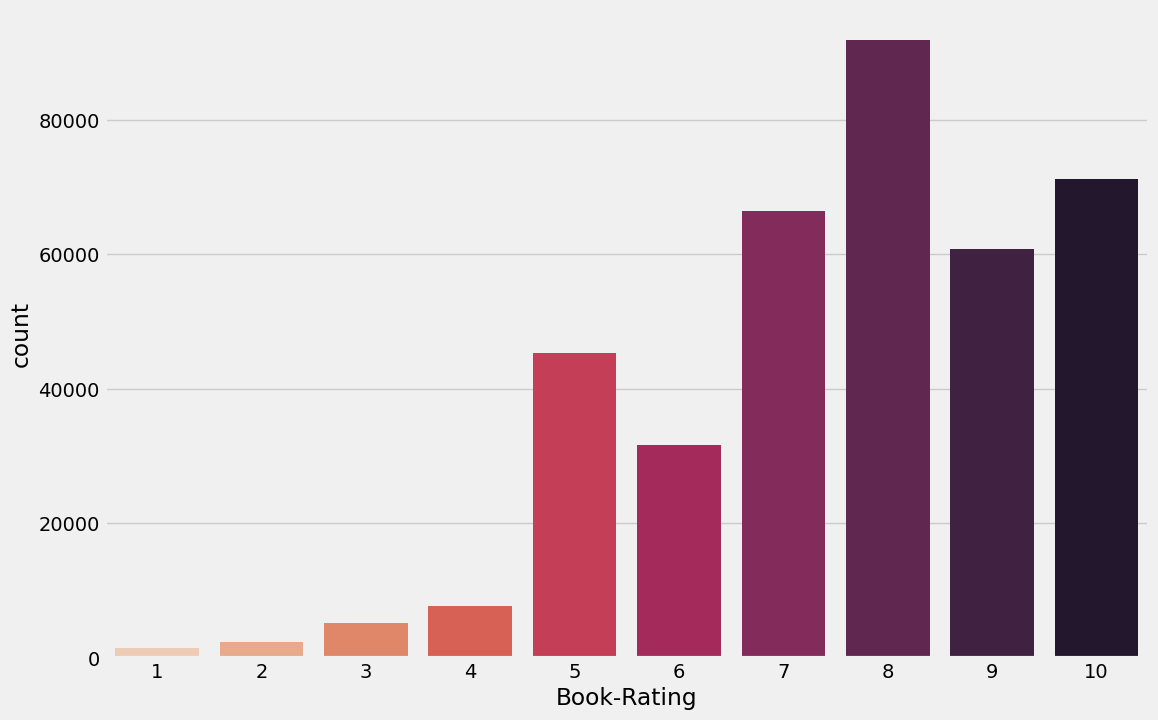

In [138]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings_explicit , x='Book-Rating', palette='rocket_r')

#Merging of all three Tables

Merging Books, Users and Rating Tables in One

In [139]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
#merging users with above merged datset
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
## #Print a concise summary of a DataFrame
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031609 entries, 0 to 1031608
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031609 non-null  object
 1   Book-Title           1031609 non-null  object
 2   Book-Author          1031609 non-null  object
 3   Year-Of-Publication  1031609 non-null  int64 
 4   Publisher            1031609 non-null  object
 5   User-ID              1031609 non-null  int64 
 6   Book-Rating          1031609 non-null  int64 
 7   Age                  1031609 non-null  int64 
 8   City                 1031609 non-null  object
 9   State                1031609 non-null  object
 10  Country              1031609 non-null  object
dtypes: int64(4), object(7)
memory usage: 94.4+ MB


**Divide complete data on the basis of Implicit and Explicit ratings **

In [140]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384074, 11)

In [141]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647535, 11)

In [142]:
# Printing top 5 rows
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada


##**Data Visualization**

Text(0.5, 1.0, 'No of books by an author (Top 15)')

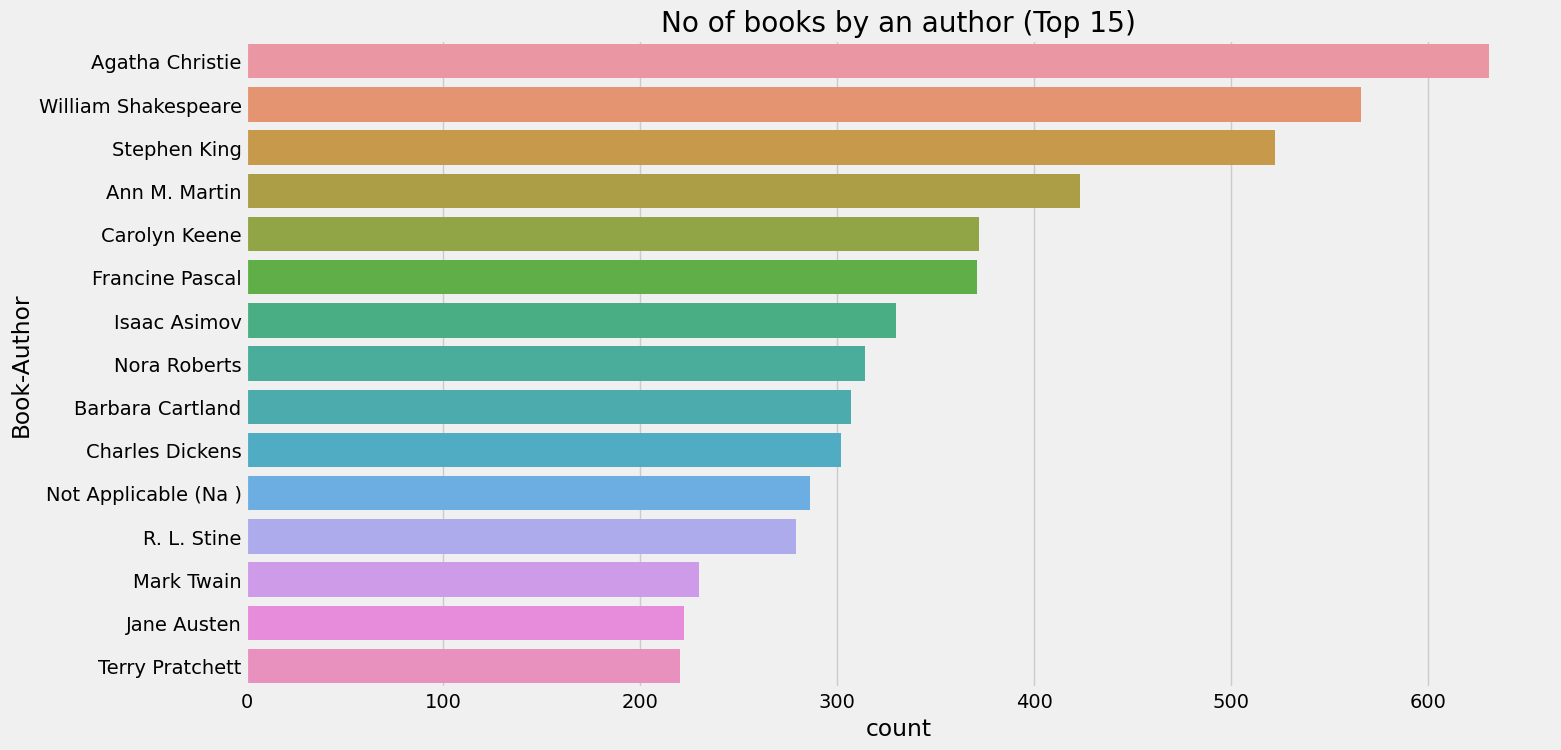

In [143]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

Text(0.5, 1.0, 'No of books published by a publisher (Top 15)')

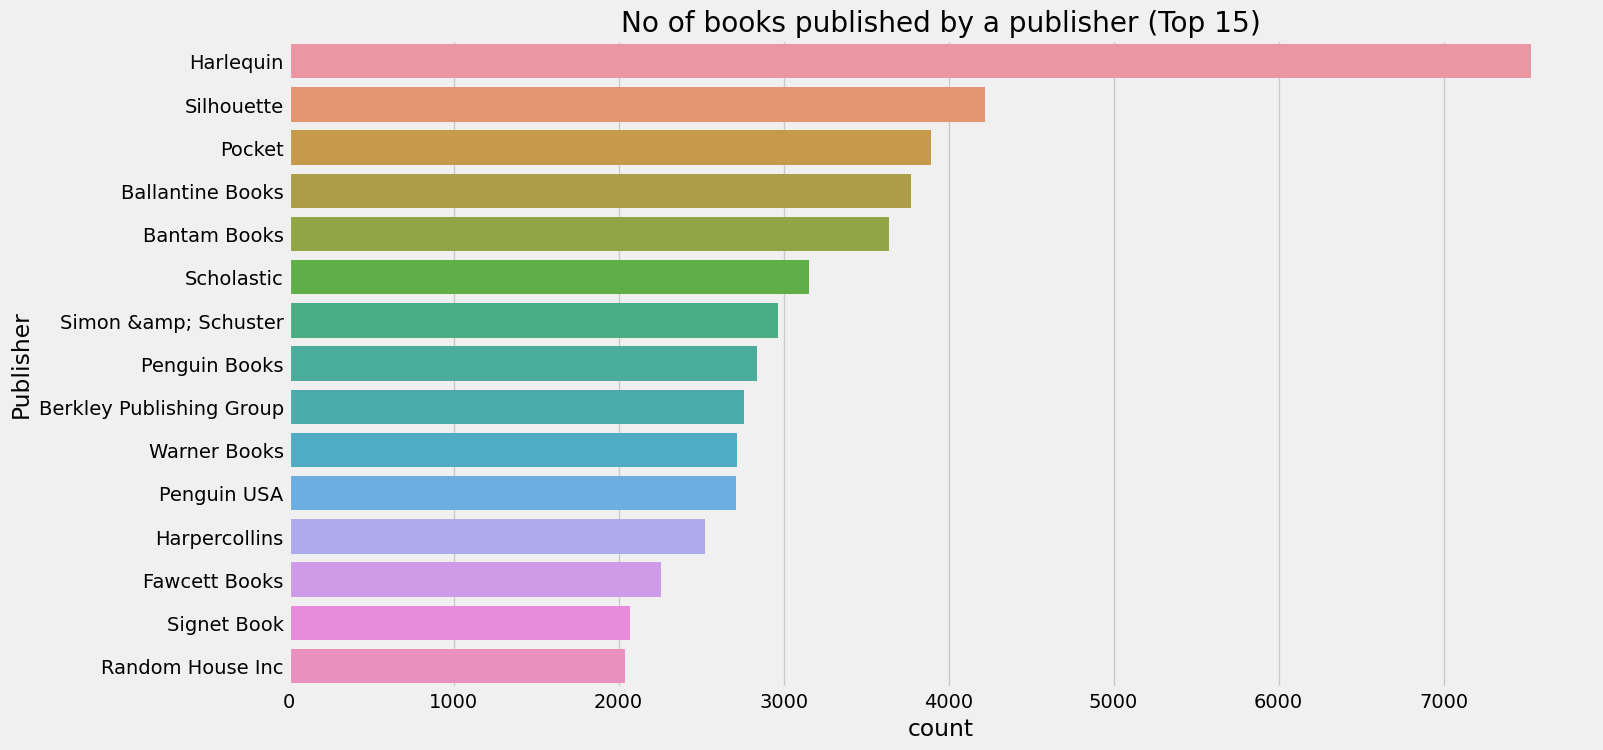

In [144]:
plt.figure(figsize=(15,8))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("No of books published by a publisher (Top 15)")

Text(0.5, 1.0, 'Explicit Ratings')

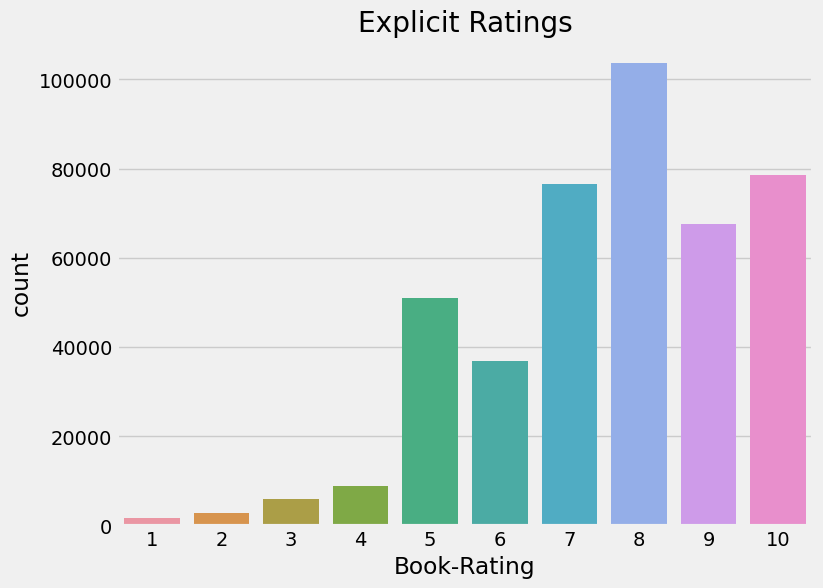

In [145]:
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

Now, This countplot of rating indicates that higher ratings are more common amongst users and rating 8 has been rated highest number of times then 10 & 7. As the problem of string 'year' values was solved in the preprocessing steps, so now there's no need to convert the data types. Plotted this interactive plot to see more accurately the 'year_of _publication'(year column) distribution.

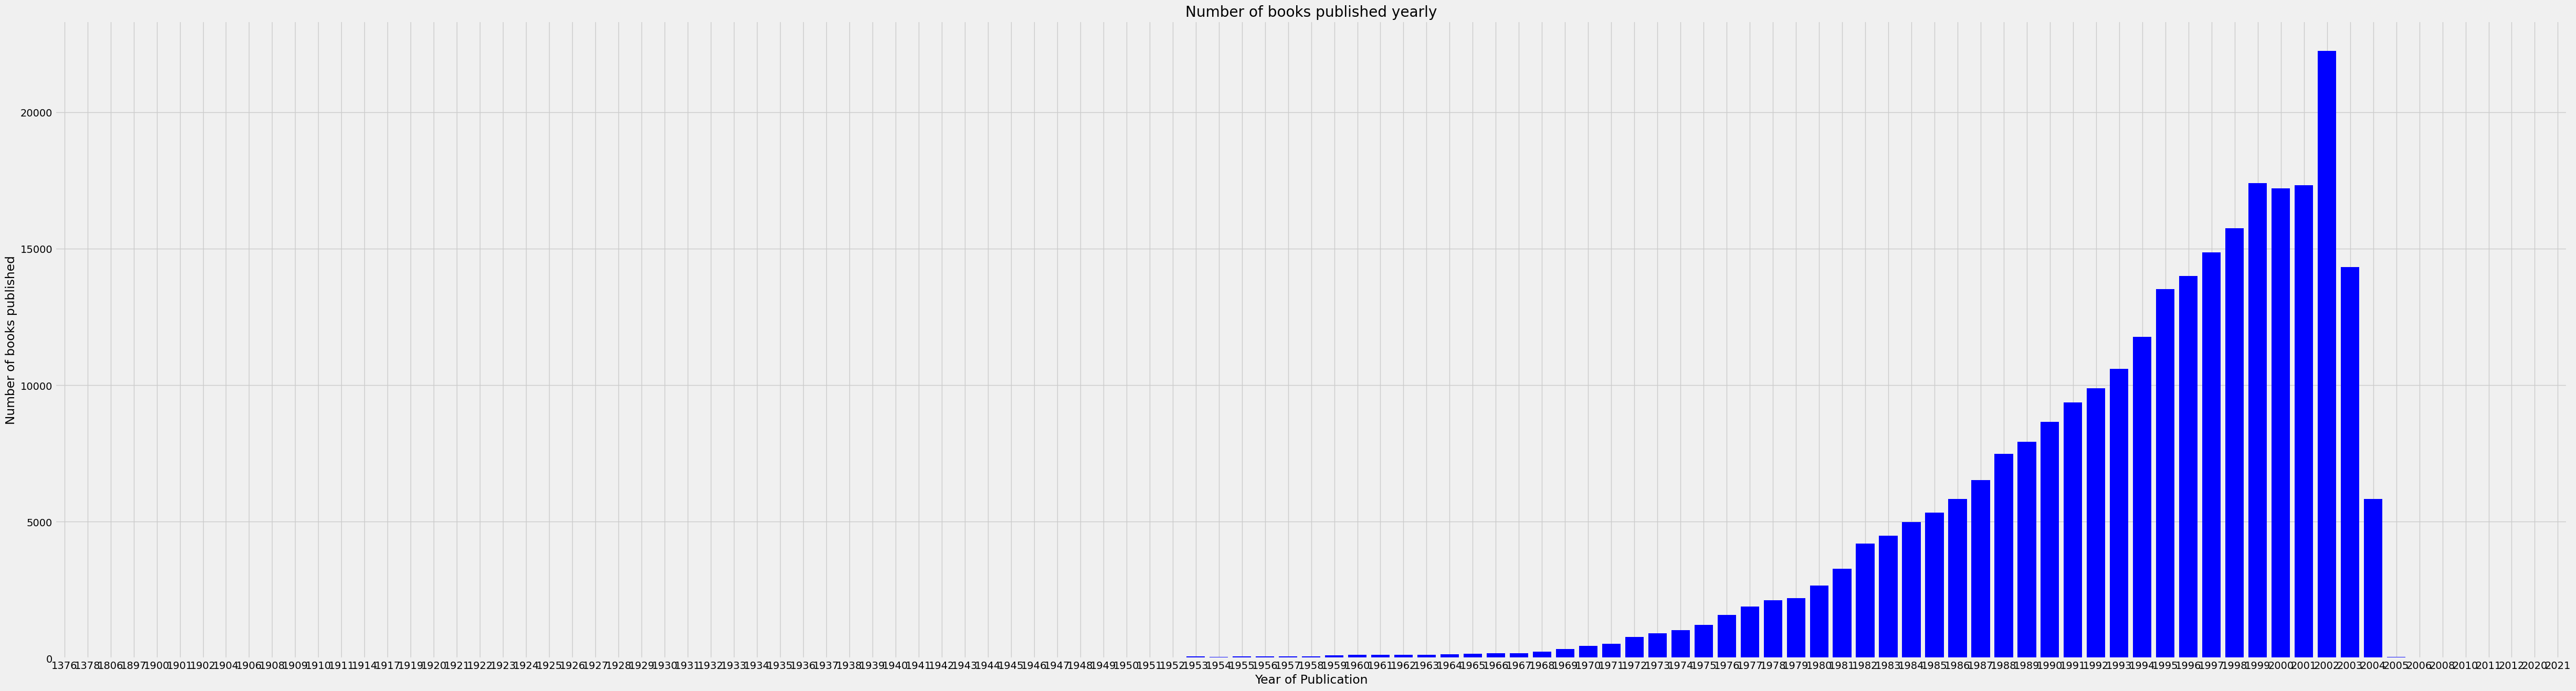

In [146]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}
#we can plot the graph "Number of books published yearly"
fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

So we can observe that publication years are somewhat between 1950 - 2005 here.

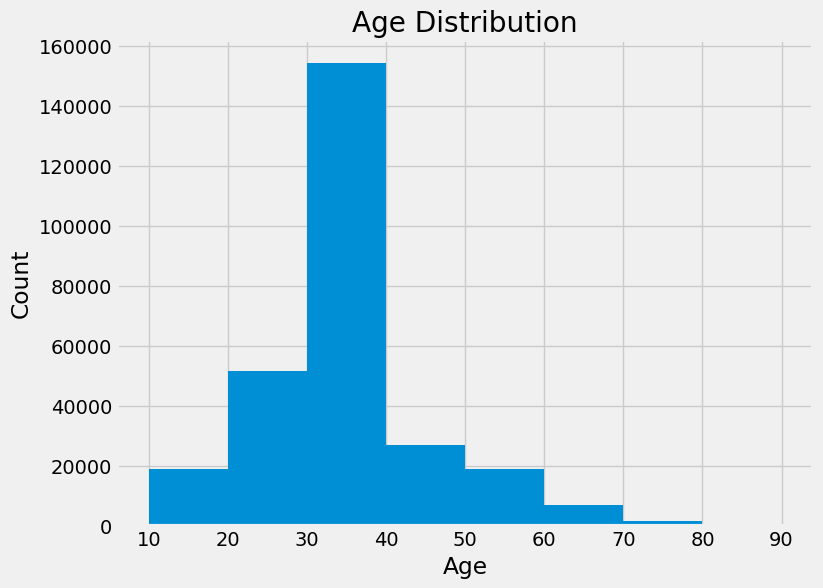

In [147]:
#Age distribution
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

We can conclude between users with age between 20-40 are highest in number.

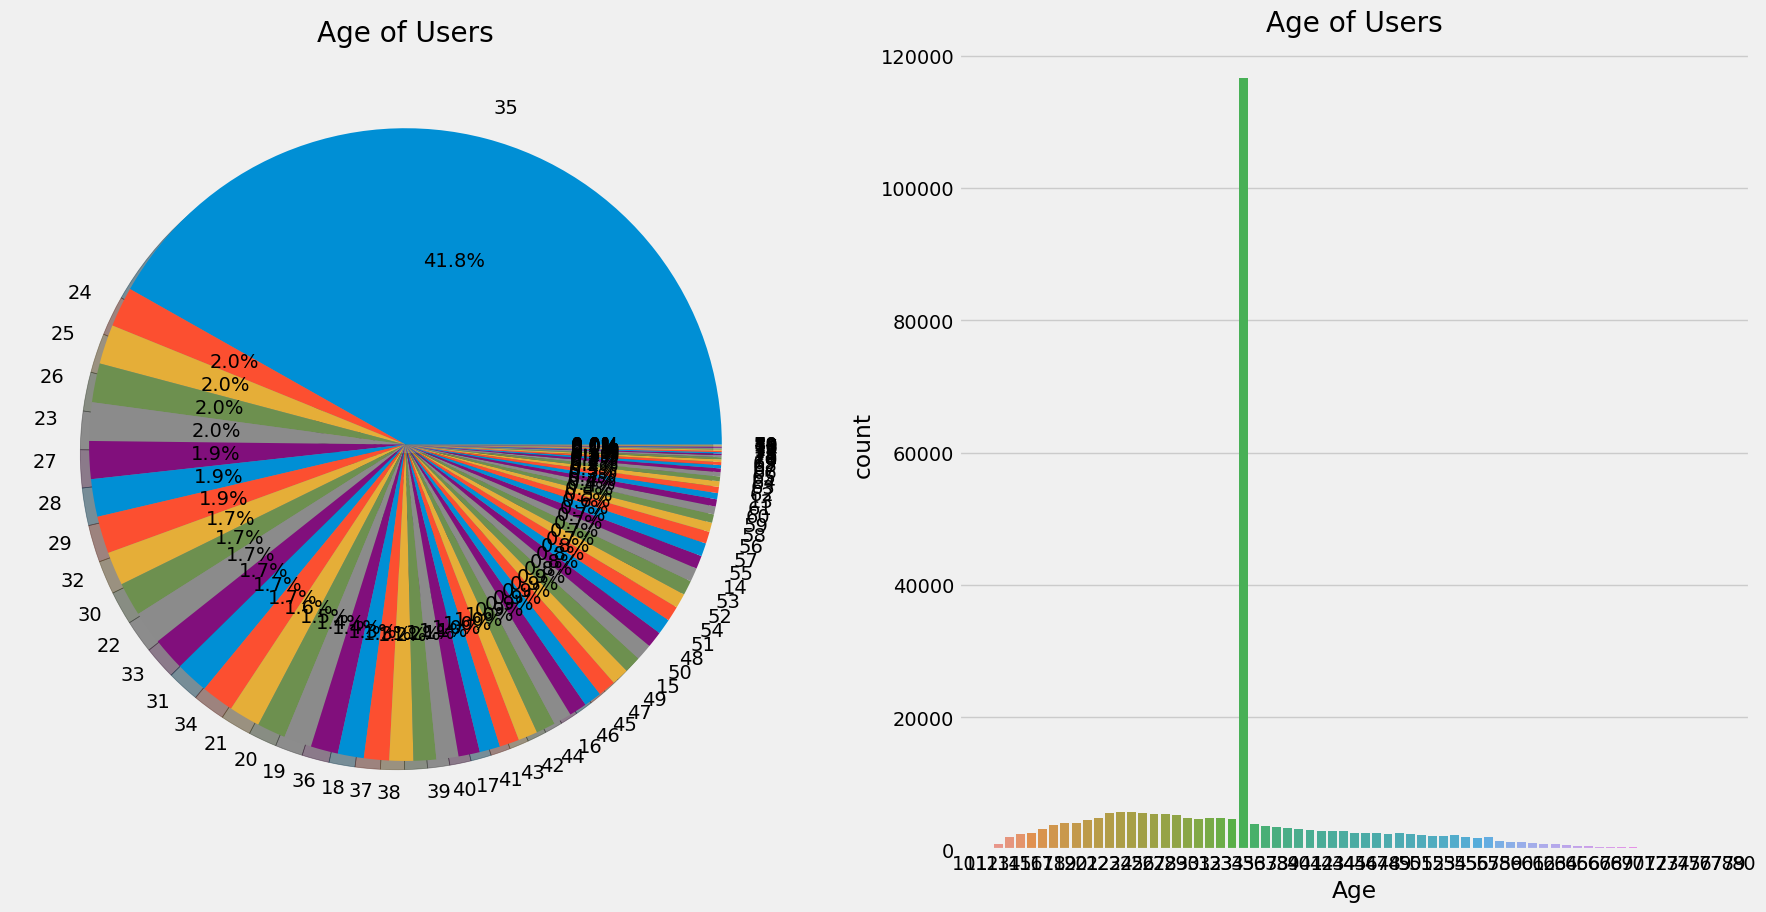

In [148]:
#Plotting pie chart of age variable
f,ax=plt.subplots(1,2,figsize=(20,10))
users.Age.value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Age of Users')
ax[0].set_ylabel('')

#Plotting countplot of age variable
sns.countplot(x= 'Age',data=users,ax=ax[1])
ax[1].set_title('Age of Users')
plt.show()


#Train - Test Split

From above plots we observed that 41.9% of age 34 group read more books compared to other age groups. Also the users with the age 60 and above do not read more books.

Text(0.5, 1.0, 'No of readers from each city (Top 15)')

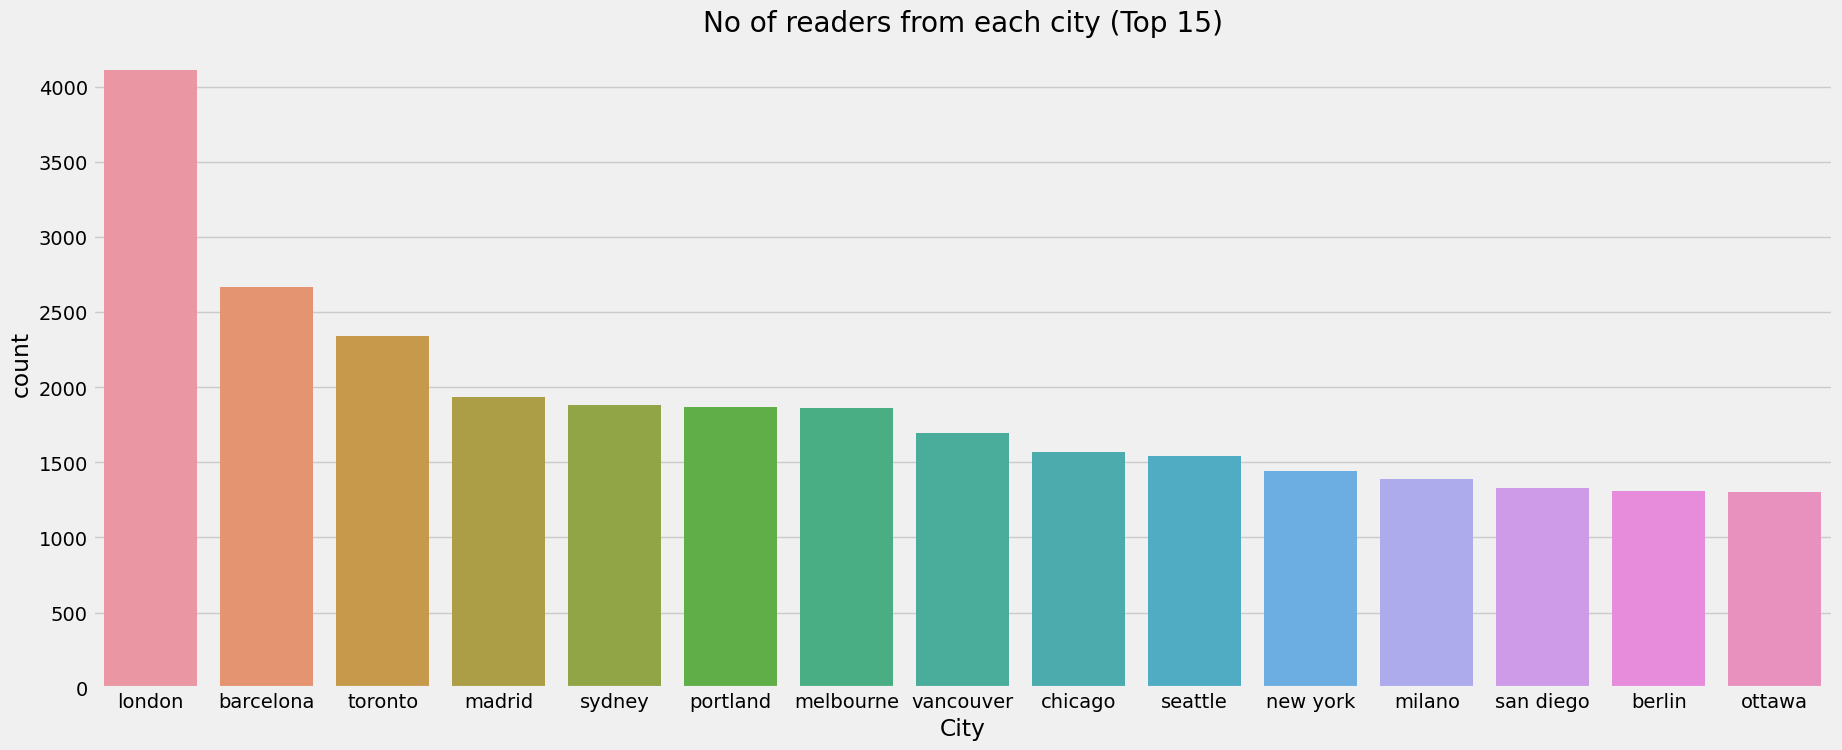

In [149]:
#top 15 cities based on user count
plt.figure(figsize=(20,8))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:15])
plt.title("No of readers from each city (Top 15)")

Here we can see that user with locations London,barcelona,toronto,madrid,sydney,ontario,melbourne are high in numbers.

Text(0.5, 1.0, 'No of readers from each state (Top 15)')

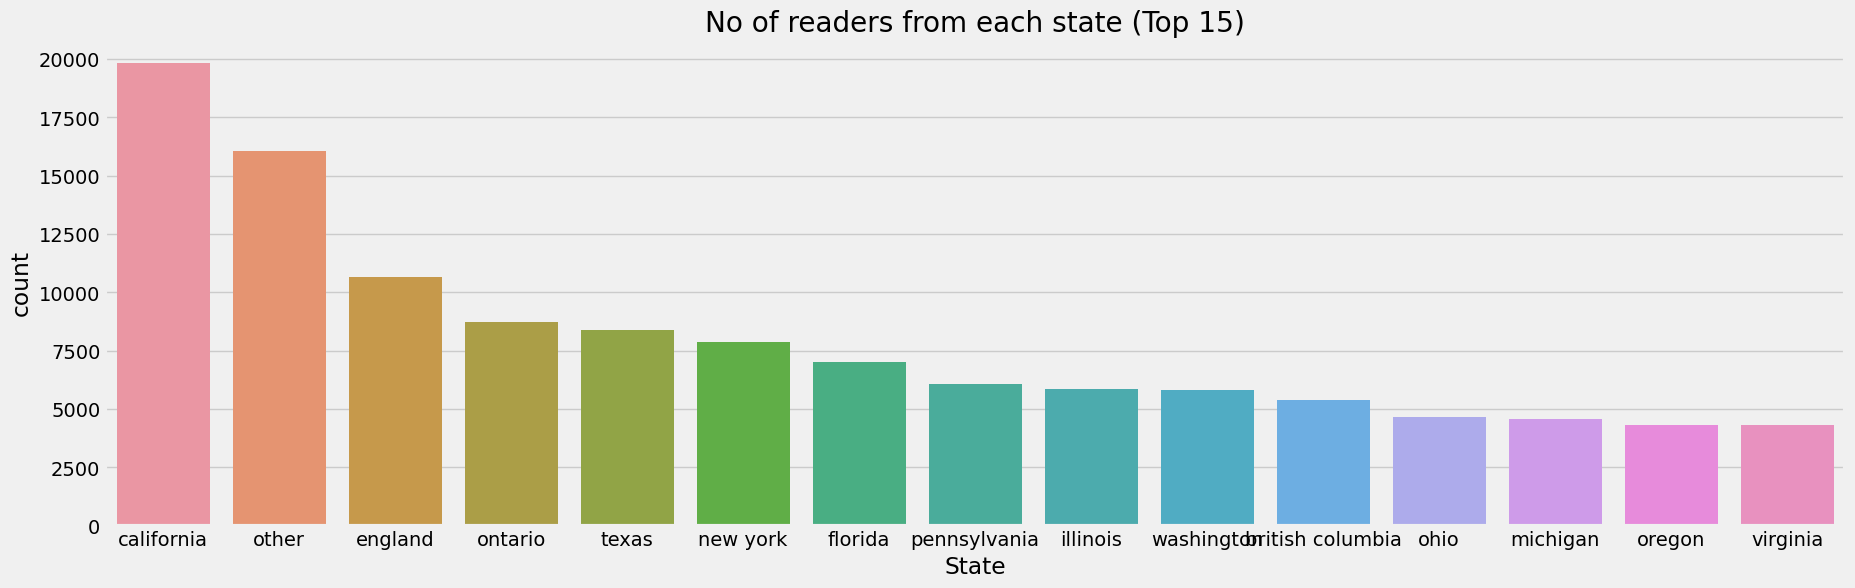

In [150]:
#top 15 States based on user count
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("No of readers from each state (Top 15)")

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

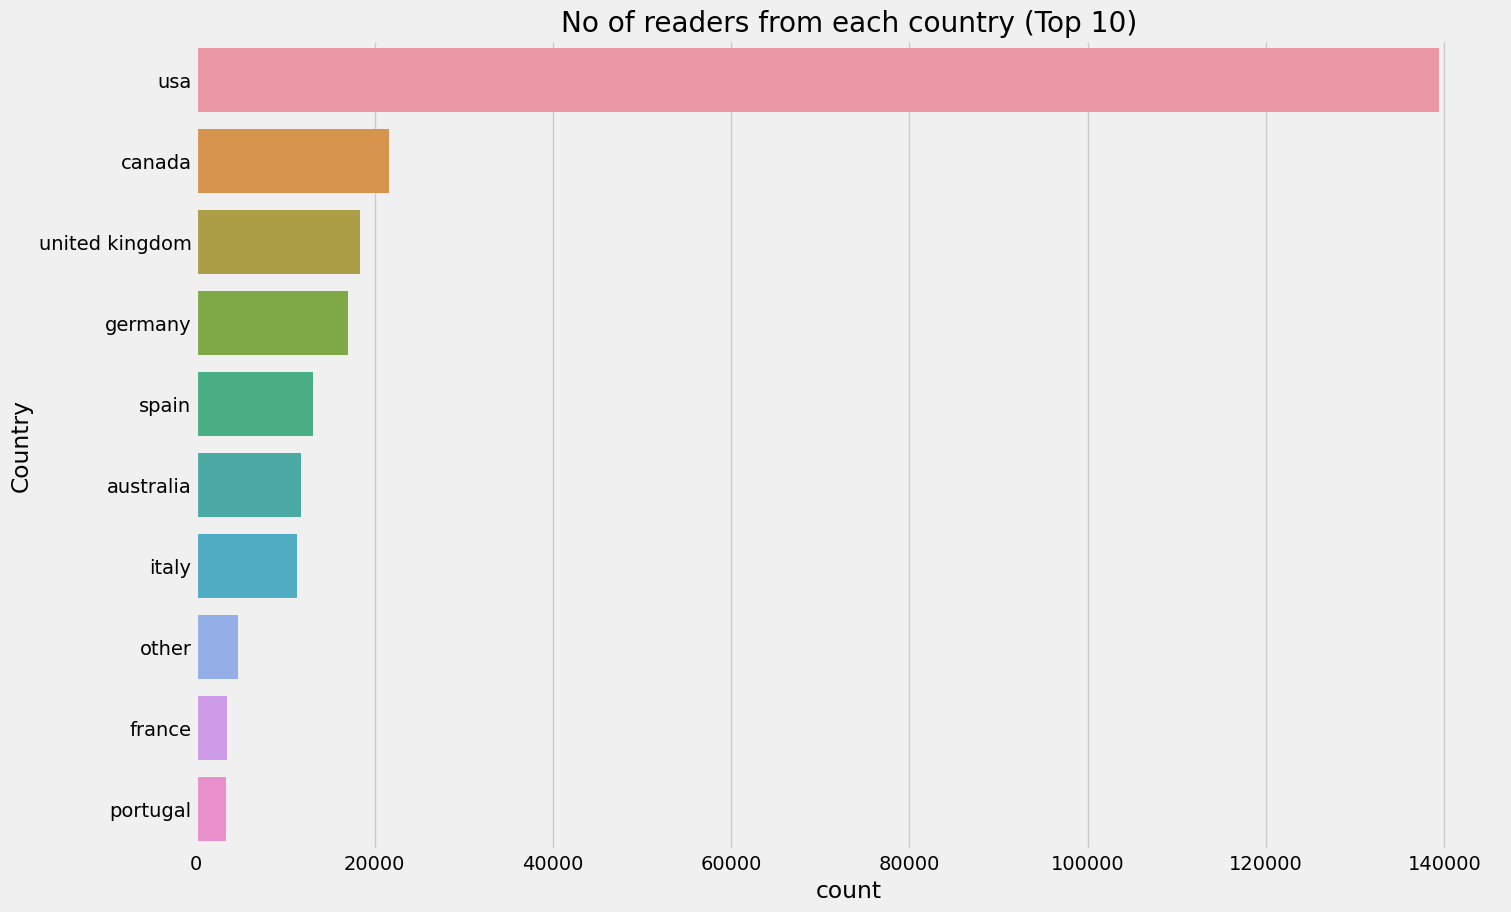

In [151]:
#top 10 Countries based on number of readers
plt.figure(figsize=(15,10))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

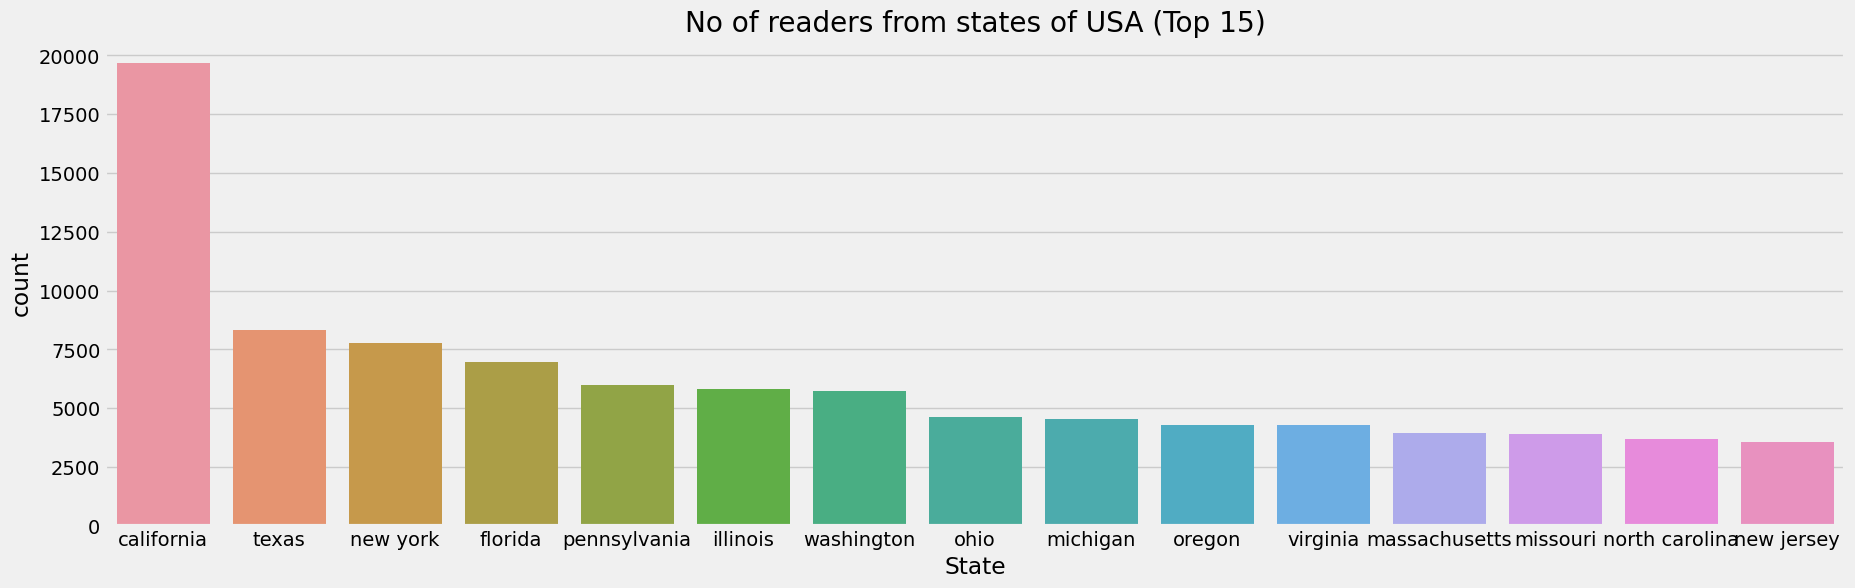

In [152]:
#Top 15 readers from states of USA
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 20)')

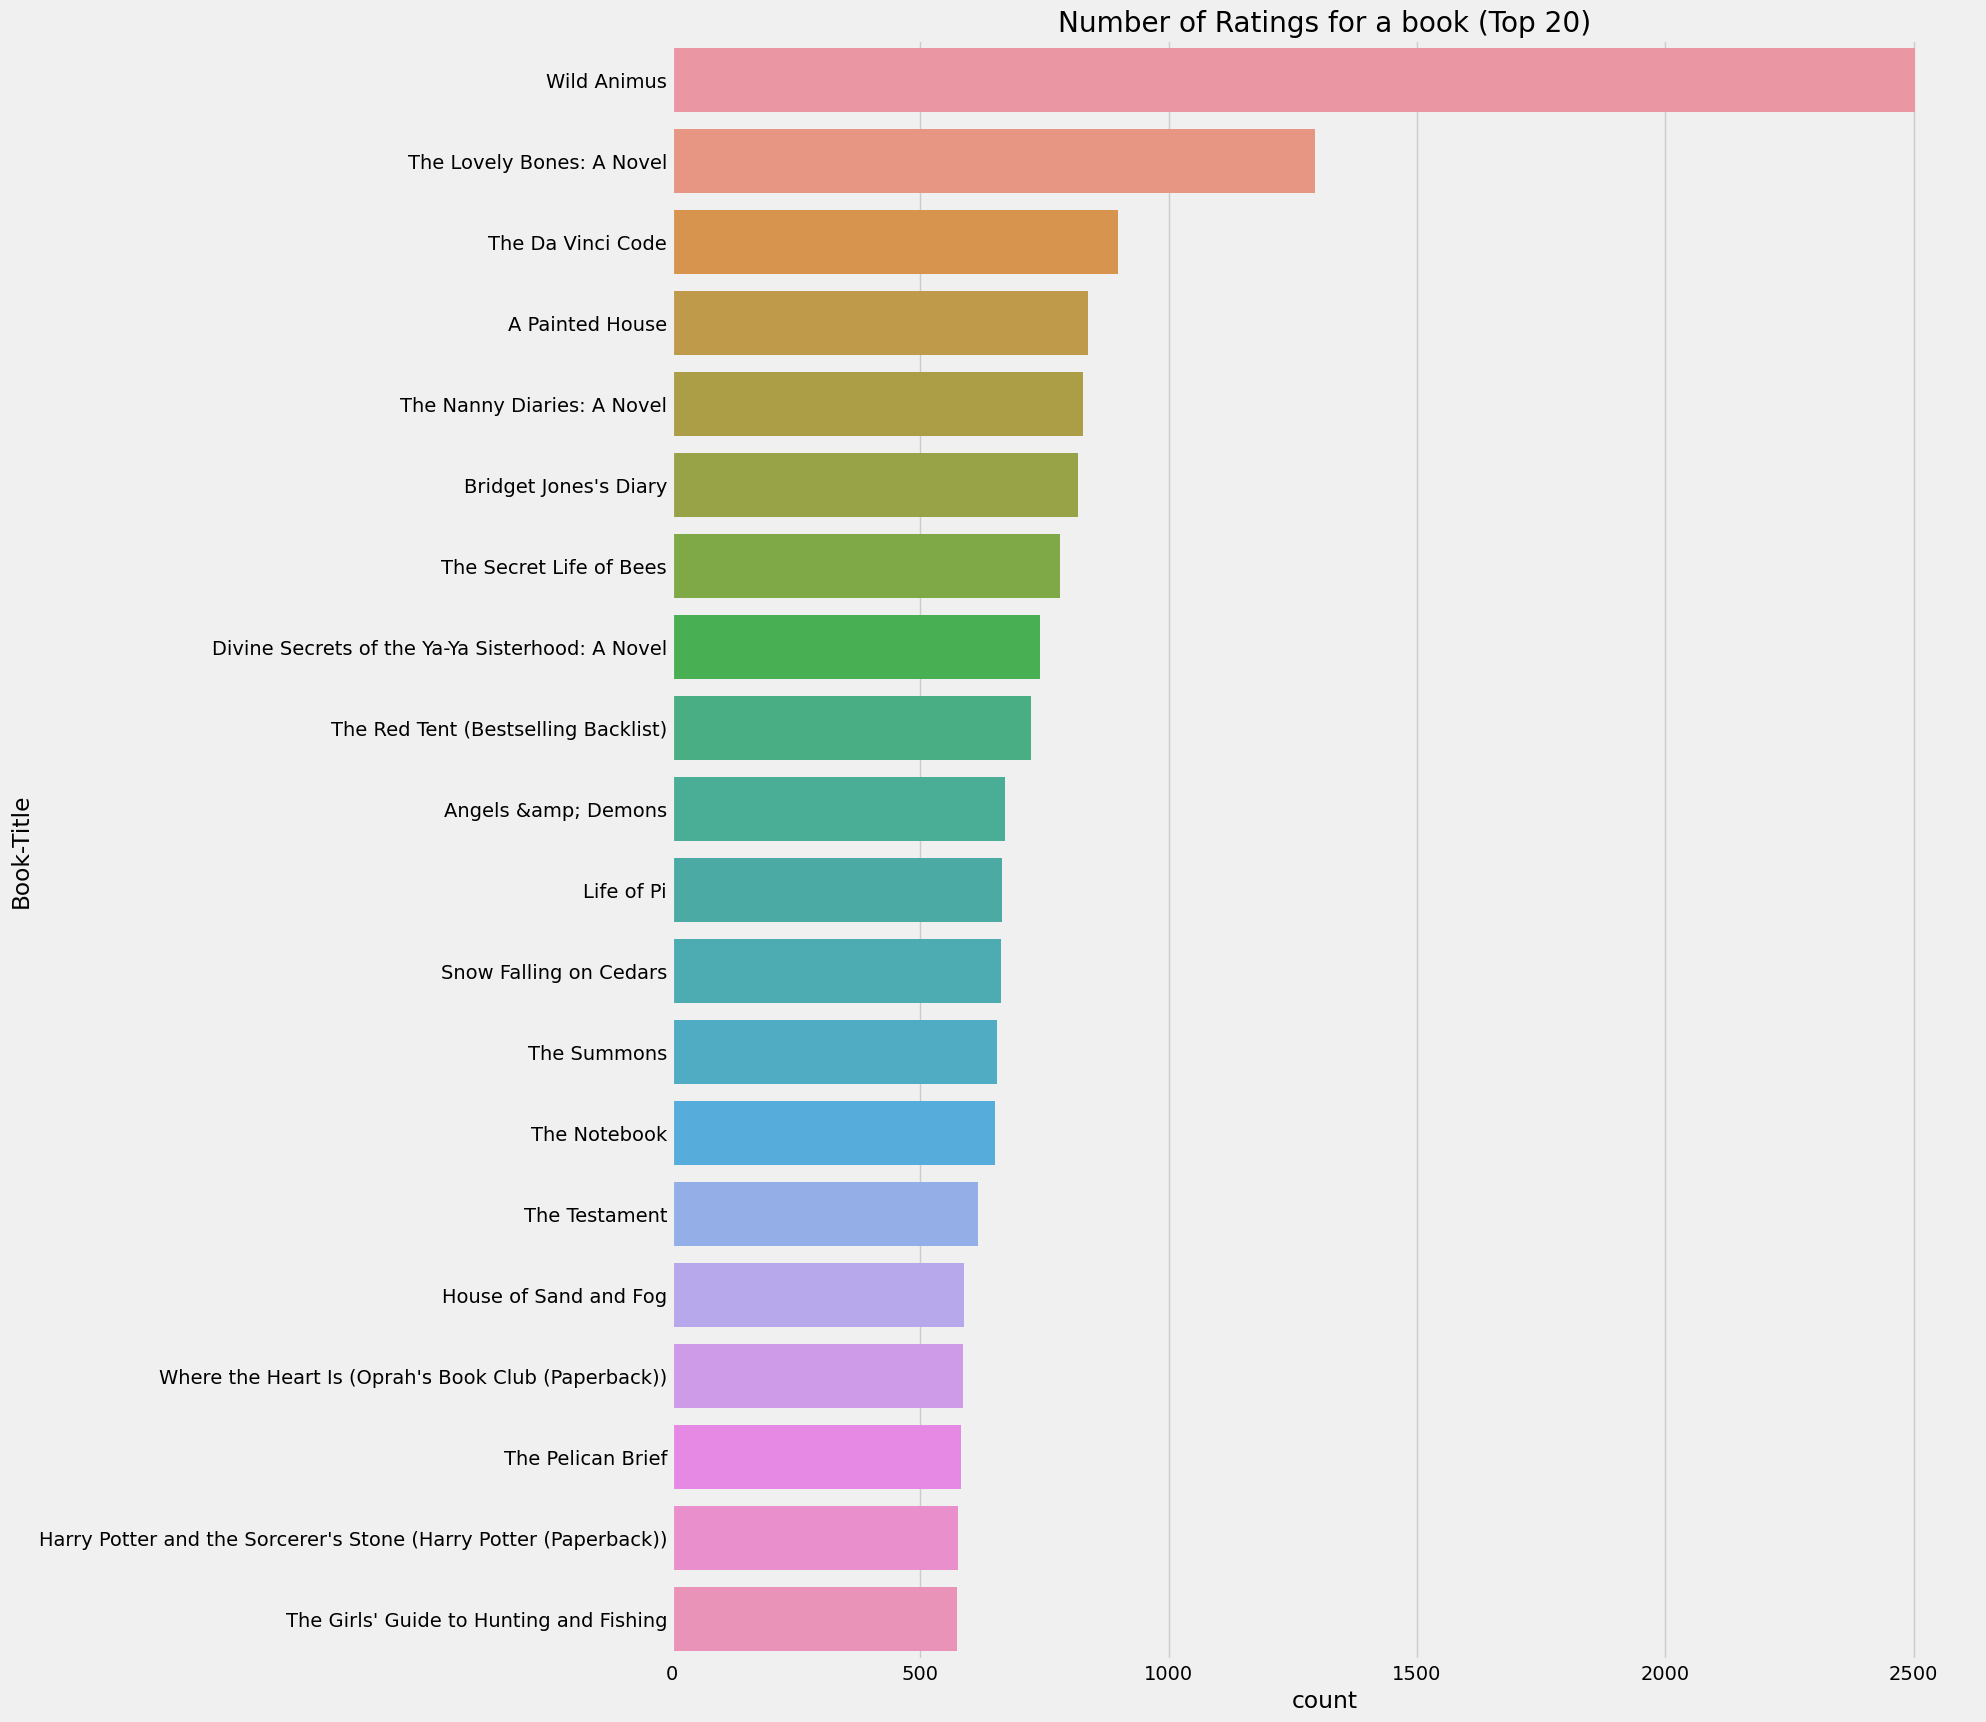

In [153]:
#polt the bar plot book title vs Rating count
plt.figure(figsize=(15,20))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:20])
plt.title("Number of Ratings for a book (Top 20)")

#2. Algorithms Implemented:

##2.1 Popularity Based Recommendation :

●  **Popular in the Whole Collection**

We have sorted the dataset according to the total ratings each of the books have received in non-increasing order and then recommended top n books.

●  **Popular at a Given Place**

The dataset was filtered according to a given place (city, state, or country) and then sorted according to total ratings they have received by the users in decreasing order of that place and recommended top n books.

●  **Books By the Same Author**, Publisher of Given Book Name

For this model, we have sorted the books by rating for the same author and same publisher of the given book and recommended top n books.

Popular Books Yearly This is the most basic model in which we have grouped all the books published in the same year and recommended the top-rated book yearly.

#2.2 Recommendation using Average Weighted Rating
We have calculated the weighted score using the below formula for all the books and recommended the books with the highest score.

score= t/(t+m)∗a + m/(m+t)∗c

where, t represents the total number of ratings received by the book m represents the minimum number of total ratings considered to be included a represents the average rating of the book and, c represents the mean rating of all the books.

#2.3 User-Item Collaborative Filtering Recommendation
Collaborative Filtering Recommendation System works by considering user ratings and finds cosine similarities in ratings by several users to recommend books. To implement this, we took only those books' data that have at least 50 ratings in all.

#2.4 Correlation Based Recommendation
For this model, we have created the correlation matrix considering only those books which have total ratings of more than 50. Then a user-book rating matrix is created. For the input book using the correlation matrix, top books are recommended.

#2.5 Nearest Neighbour Based Recommendation
To train the Nearest Neighbours model, we have created a compressed sparse row matrix taking ratings of each Book by each User individually. This matrix is used to train the Nearest Neighbours model and then to find n nearest neighbors using the cosine similarity metric.

**2.5.1 SVD(Singular Value Decomposition) Based recommendation System: The SVD(Singular Value Decomposition)** is used as a collaborative filtering technique. It uses a matrix structure where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users.

#2.6 Content Based Recommendation
This system recommends books by calculating similarities in Book Titles. For this, TF-IDF feature vectors were created for unigrams and bigrams of Book-Titles; only those books' data has been considered which are having at least 80 ratings.

#2.7 Hybrid Approach (Collaborative+Content) Recommendation
A hybrid recommendation system was built using the combination of both content-based filtering and collaborative filtering systems. A percentile score is given to the results obtained from both content and collaborative filtering models and is combined to recommend top n books.

In [154]:
 #taking using input which book he/she choose
bookName = input("Enter a book name: ")
#no of recomendation they expected from our recomendation system
number = int(input("Enter number of books to recommend: "))

# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to recommend: 1


#1. Popularity Based (Top In whole collection)
Now let's try to build our first recommendation system based on popularity. These systems check about the product or movie which are in trend or are most popular among the users and directly recommend those.

In [155]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        result = pd.merge(data, books, on='ISBN', left_index = False)
        return result
    return "Invalid number of books entered!!"

In [156]:
print("Top", number, "Popular books are: ")
popularity_based(dataset1, number)

Top 1 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"


#1.2. Popularity Based (Top In a given place)

In [157]:
# we want to recommend Popular books in a given place
def search_unique_places(dataframe, place):
    place = place.lower()

    if place in list(dataframe['City'].unique()):
        return dataframe[dataframe['City'] == place]
    elif place in list(dataframe['State'].unique()):
        return dataframe[dataframe['State'] == place]
    elif place in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == place]
    else:
        return "Invalid Entry"

In [158]:
# taking from user which place he want to search
place = input("Enter the name of place: ")
data = search_unique_places(dataset1, place)

if isinstance(data, pd.DataFrame):
    data = popularity_based(data, number)

data

Enter the name of place: India


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0971880107,3,Wild Animus,Rich Shapero,2004,Too Far


#1.3 Books by same author, publisher of given book name

In [159]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [160]:
#Search based on same author,and publications of similar to user input book
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

In [161]:
if bookName in list(dataset1['Book-Title'].unique()):
    d = dataset1[dataset1['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")


Books by same Author:

Harry Potter and the Goblet of Fire (Book 4)


Books by same Publisher:

The Seeing Stone


#1.4. Books popular Yearly

In [162]:
# most popular book in particular year based on rating
data = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False)
data = pd.merge(data, books, on='ISBN', left_index = False)

years = set()
indices = []
for ind, row in data.iterrows():
    if row['Year-Of-Publication'] in years:
        indices.append(ind)
    else:
        years.add(row['Year-Of-Publication'])

data = data.drop(indices)
data = data.drop('Book-Rating', axis = 1)
data = data.sort_values('Year-Of-Publication')

pd.set_option("display.max_rows", None, "display.max_columns", None)
data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
73895,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz
73896,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus
130309,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable American Authors)",Benjamin Franklin,1806,Reprint Services Corp
81469,1551103982,The Cycling Adventures of Coconut Head: A North American Odyssey,Ted Schredd,1900,Graphic Arts Center Pub Co
125519,0671397214,JOY OF MUSIC P,Leonard Bernstein,1901,Fireside
48634,0373226888,Tommy's Mom,Linda O. Johnston,1902,Harlequin
104339,038528120X,CATCH 22,JOSEPH HELLER,1904,Delta
103193,0404089119,Charlotte Bronte and Her Sisters,Clement K. Shorter,1906,Ams Pr
24664,0911662251,Kybalion: A Study of the Hermetic Philosophy of Ancient Egypt and Greece,Three Initiates,1908,Yoga Publication Society
53807,0892760508,New Birth,Kenneth Hagin,1911,Faith Library Publications


#2. Average Weighted Ratings

In [163]:
# create a copy of df(average rating df)
avg_r_df = dataset1.copy()
# calculate the average ratings
avg_r_df['Average Rating']=dataset1.groupby('ISBN')['Book-Rating'].transform('mean')
# calculate the total ratings given every book
avg_r_df['Total-Ratings']=avg_r_df.groupby('ISBN')['Book-Rating'].transform('count')
# show average-rating-dataframe
avg_r_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country,Average Rating,Total-Ratings
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada,7.666667,9
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada,5.000000,1
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada,5.000000,1
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada,5.000000,1
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada,6.000000,1


In [164]:
# mean_ratin - Mean vote across the whole
mean_ratin = avg_r_df['Average Rating'].mean()

# Minimum number of votes required to be in the chart
# choose the top 90 percentile of the data
m = avg_r_df['Total-Ratings'].quantile(0.90)
print(f'C={mean_ratin} , m={m}')

# choosing total ratings in dataset greater than the 90th percentile
avg_r_90_percent = avg_r_df.loc[avg_r_df['Total-Ratings'] >= m]
# print the average-rating-dataframe 90th percentile
print(f'The data shape of average ratings df before slicinng based on 90 percentile {avg_r_df.shape} after slicing {avg_r_90_percent.shape}')

C=7.626863573165586 , m=65.0
The data shape of average ratings df before slicinng based on 90 percentile (384074, 13) after slicing (38599, 13)


In [165]:
# calc the weighted average of books
def weightedRating(x, m=m, C=mean_ratin):
    ''' returns weighted avarage of items, taken is x = dataframe,
        m = top 90 percentile data, c = mean-rating of the dataset'''
    #  v - number of votes
    v = x['Total-Ratings']
    # R - Average Rating
    R = x['Average Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [166]:
# calc score(weighted_average)
avg_r_90_percent['Score'] = avg_r_90_percent.apply(weightedRating, axis=1)
# sort based on the best ones(highest-weighted-avg)
avgwr_df = avg_r_90_percent.drop_duplicates('ISBN').sort_index()
#Sorting books based on score calculated above
avgwr_df = avgwr_df.sort_values('Score', ascending=False)
recomm_number =5
print("Book recommendation based of on Weighted Average ratings :-\n")
# choose the required nummber of books
avgwr_df[['Book-Title', 'Total-Ratings', 'Average Rating', 'Score']].reset_index(drop=True).head(recomm_number)

# avgwr_df.shape

Book recommendation based of on Weighted Average ratings :-



,Book-Title,Total-Ratings,Average Rating,Score
0,Harry Potter and the Goblet of Fire (Book 4),137,9.262774,8.736367
1,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),315,8.936508,8.712490
2,Harry Potter and the Order of the Phoenix (Book 5),207,9.038647,8.701273
3,To Kill a Mockingbird,214,8.943925,8.637083
4,Harry Potter and the Prisoner of Azkaban (Book 3),133,9.082707,8.604778


#3. Collaborative Filtering

Selecting books with total ratings equals to or more than 50 (Because of availability of limited resources) 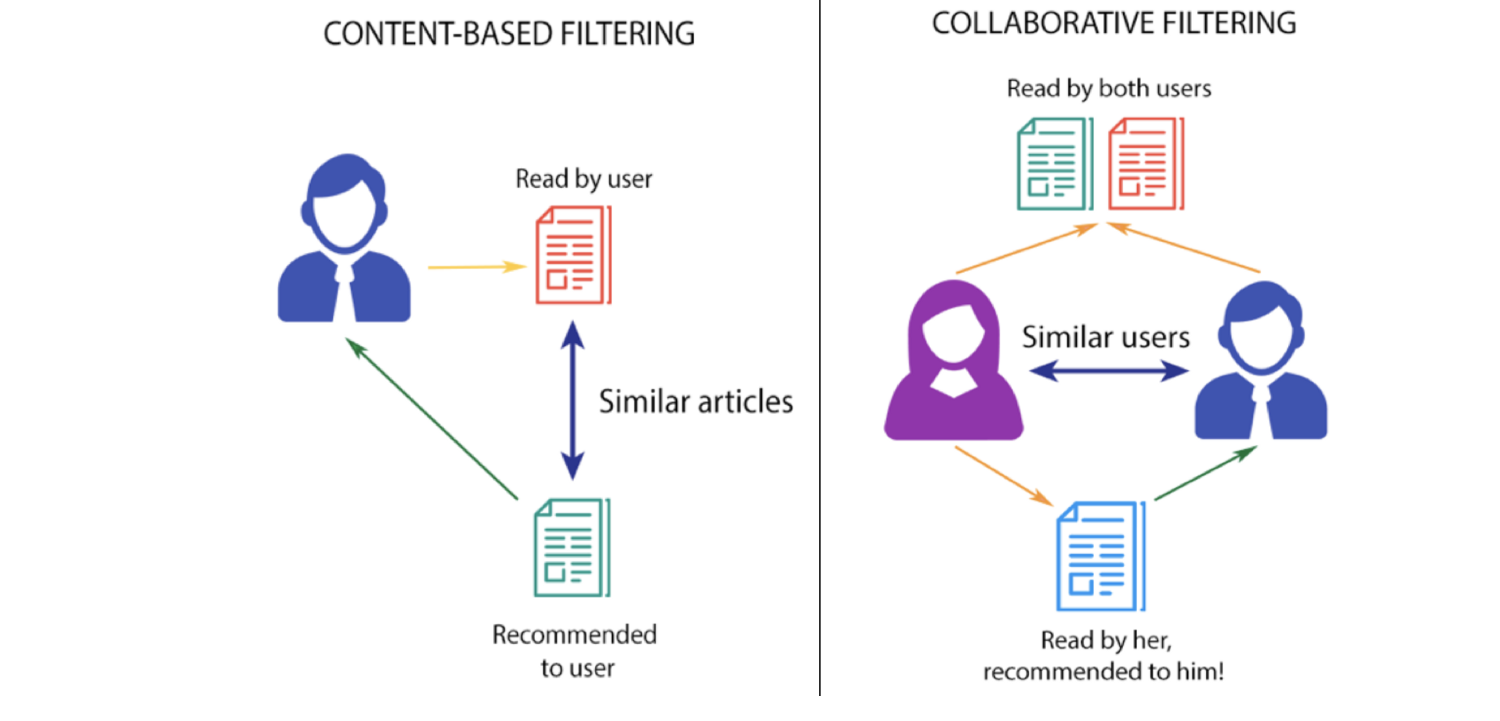

In [167]:
df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

#3.1 User - Item Collaborative Filtering
Collaborative Filtering Recommendation System works by considering user ratings and finds cosine similarities in ratings by several users to recommend books. To implement this, we took only those books' data that have at least 50 ratings in all.

In [168]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [169]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [170]:
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    """
    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)

    print("\nRECOMMENDATIONS:\n")

    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative

In [171]:
k = list(dataset1['Book-Title'])
m = list(dataset1['ISBN'])
collaborative = getTopRecommandations(m[k.index(bookName)])


Input Book:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Prisoner of Azkaban (Book 3)


#3.2 Correlation Based
For this model, we have created the correlation matrix considering only those books which have total ratings of more than 50. Then a user-book rating matrix is created. For the input book using the correlation matrix, top books are recommended.

In [172]:
popularity_threshold = 50

user_count = dataset1['User-ID'].value_counts()
data = dataset1[dataset1['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['Book-Rating'].value_counts()
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)

In [173]:
average_rating = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,4.390706,2502
0316666343,8.185290,1295
0385504209,8.426230,884
0060928336,7.887500,732
0312195516,8.182768,723


In [174]:
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['ISBN']), books, on='ISBN')
print("\n Recommended Books: \n")
corr_books


 Recommended Books: 



,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic


3.3 Nearest Neighbours Based

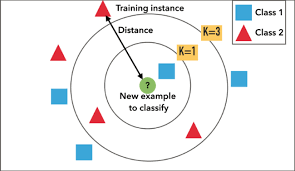

kNN(k-Nearest Neighbors) as an algorithm seems to be inspired from real life. The full k-nearest neighbors algorithm works much in the way some of us ask for recommendations from our friends. First, we start with people whose taste we feel we share, and then we ask a bunch of them to recommend something to us. If many of them recommend the same thing, we deduce that we’ll like it as well. Our behaviour is guided by the friends we grew up with.kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors.

Here we assume that users who given ratings more than 200 are users who read atleast 20 books(suppose on user given rating 10/10 so  minimum he read books(200 ratings/10 ratings per book=20).For statisfical significance we should consider only the data of user who given more than 200 ratings. To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [175]:
data = (dataset1.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, dataset1, on='Book-Title', left_index = False)
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [176]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]])


Recommended books:

Harry Potter and the Chamber of Secrets (Book 2)


#3.4 SVD(Singular Value Decomposition) Based recommendation System
The SVD(Singular Value Decomposition) is used as a collaborative filtering technique. It uses a matrix structure where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users.

In [177]:
ratings_explicit.rename(columns = {'User-ID':'user_id' ,'ISBN':'isbn' ,'Book-Rating':'book_rating'},inplace=True)

In [178]:
user_ratings_threshold = 3

filter_users = ratings_explicit['user_id'].value_counts()
filter_users_list = filter_users[filter_users >= user_ratings_threshold].index.to_list()

df_ratings_top = ratings_explicit[ratings_explicit['user_id'].isin(filter_users_list)]

print('Filter: users with at least %d ratings\nNumber of records: %d' % (user_ratings_threshold, len(df_ratings_top)))

Filter: users with at least 3 ratings
Number of records: 327389


In [179]:
book_ratings_threshold_perc = 0.1
book_ratings_threshold = len(df_ratings_top['isbn'].unique()) * book_ratings_threshold_perc

filter_books_list = df_ratings_top['isbn'].value_counts().head(int(book_ratings_threshold)).index.to_list()
df_ratings_top = df_ratings_top[df_ratings_top['isbn'].isin(filter_books_list)]

print('Filter: top %d%% most frequently rated books\nNumber of records: %d' % (book_ratings_threshold_perc*100, len(df_ratings_top)))

Filter: top 10% most frequently rated books
Number of records: 160898


SVD and NMF models comparison Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.

In [180]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811604 sha256=5e6d7dd6c75f7e5ebf941ad44c116ada5afa1d6dfb4c28e14b5b1ee6a5754e38
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

The name SurPRISE (roughly) stands for Simple Python Recommendation System Engine.

In [181]:
from surprise import Dataset, Reader
from surprise import SVD, NMF
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [182]:
df=df_ratings_top.copy()
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['user_id', 'isbn', 'book_rating']], reader)

In [183]:
from surprise import SVD, model_selection, accuracy
# Using the famous SVD algorithm
model = SVD()

# Train on explicit_rating dataset
# Runing 5-fold cross-validation and print results
%time model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5847  1.5995  1.5999  1.5884  1.5890  1.5923  0.0062  
Fit time          4.31    2.99    4.45    7.97    6.33    5.21    1.74    
Test time         0.41    0.73    0.62    0.43    1.02    0.64    0.22    
CPU times: user 24.2 s, sys: 188 ms, total: 24.4 s
Wall time: 33 s


{'test_rmse': array([1.58471734, 1.59952241, 1.59990226, 1.58835667, 1.58901126]),
 'fit_time': (4.308111190795898,
  2.9941747188568115,
  4.44602370262146,
  7.967963457107544,
  6.330942392349243),
 'test_time': (0.4121816158294678,
  0.7316222190856934,
  0.6150851249694824,
  0.43354320526123047,
  1.0160605907440186)}

#Train - Test Split

In [184]:
# Taking an arbitrary user-id and item-id to test our model.
uid = 276744
iid = '038550120X'
pred = model.predict(uid, iid, verbose=True)

user: 276744     item: 038550120X r_ui = None   est = 7.54   {'was_impossible': False}


In [185]:
print(f'The estimated rating for the book with ISBN code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rating= ratings_explicit[(ratings_explicit.user_id==pred.uid) &
                             (ratings_explicit.isbn==pred.iid)].book_rating.values[0]
print(f'The real rating given for this was {actual_rating:.2f}.')

The estimated rating for the book with ISBN code 038550120X from user #276744 is 7.54.

The real rating given for this was 7.00.


In [186]:
# train test split on our data
trainset, testset = model_selection.train_test_split(data, test_size=0.2)
# creating svd model
model = SVD()
# Fit the model
model.fit(trainset)
# Predict the model on test data
predictions = model.test(testset)
# Evaluating model
accuracy.rmse(predictions)

RMSE: 1.5863


1.5862766805653772

We see the RMSE score has improved a lot. It is now on average 1.5784 which is pretty good.

**Testing Results**

In [187]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'isbn', 'actual_rating', 'pred_rating', 'details'])
df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)
df_pred.sample(5)

,user_id,isbn,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
22439,202000,0805019359,6.0,7.356686,False,7.0,1.356686
18277,180378,0886774691,10.0,8.188632,False,8.0,1.811368
10343,105986,0451207645,8.0,7.882177,False,8.0,0.117823
15457,146803,0385472943,9.0,7.860389,False,8.0,1.139611
19993,41841,0385505833,7.0,6.762656,False,7.0,0.237344


Distribution of actual and predicted ratings in the test set According to the distribution of actual ratings of books in the test set, the biggest part of users give positive scores - between 7 and 10. The mode equals 8 but count of ratings 7, 9, 10 is also noticeable. The distribution of predicted ratings in the test set is visibly different. One more time, 8 is a mode but scores 7, 9 and 10 are clearly less frequent. It shows that the recommender system is not perfect and it cannot reflect the real distribution of book ratings.

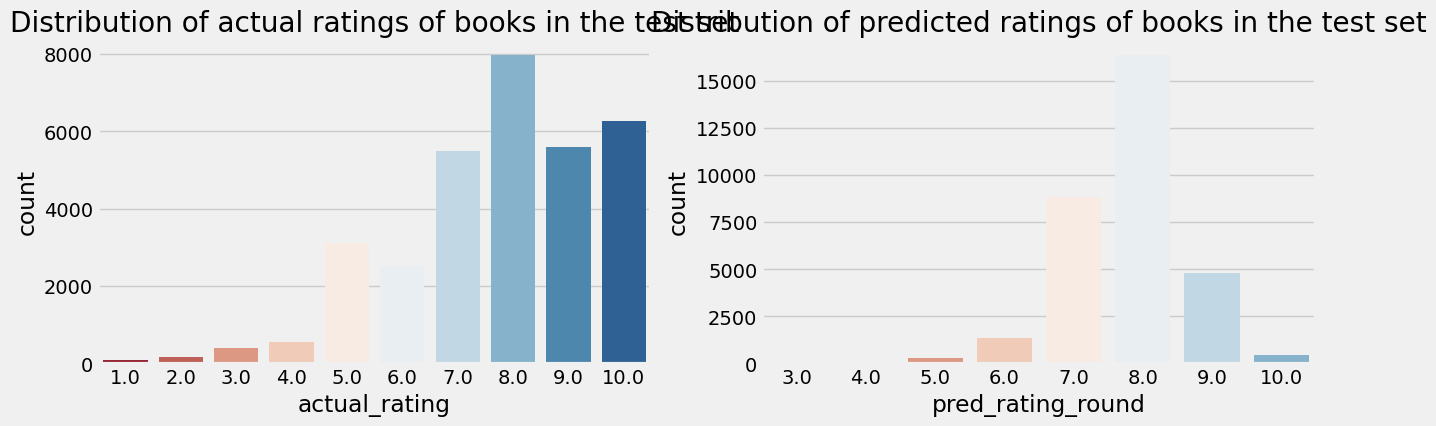

In [188]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

Absolute error of predicted ratings The distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 1. There is a long tail that indicates that there are several observations for which the absolute error was close to 10. How good/bad the model is with predicting certain scores? As expected from the above charts, the model deals very well with predicting score = 8 (the most frequent value). The further the rating from score = 8, the higher the absolute error. The biggest errors happen to observations with scores 1 or 2 which indicates that probably the model is predicting high ratings for those observations.

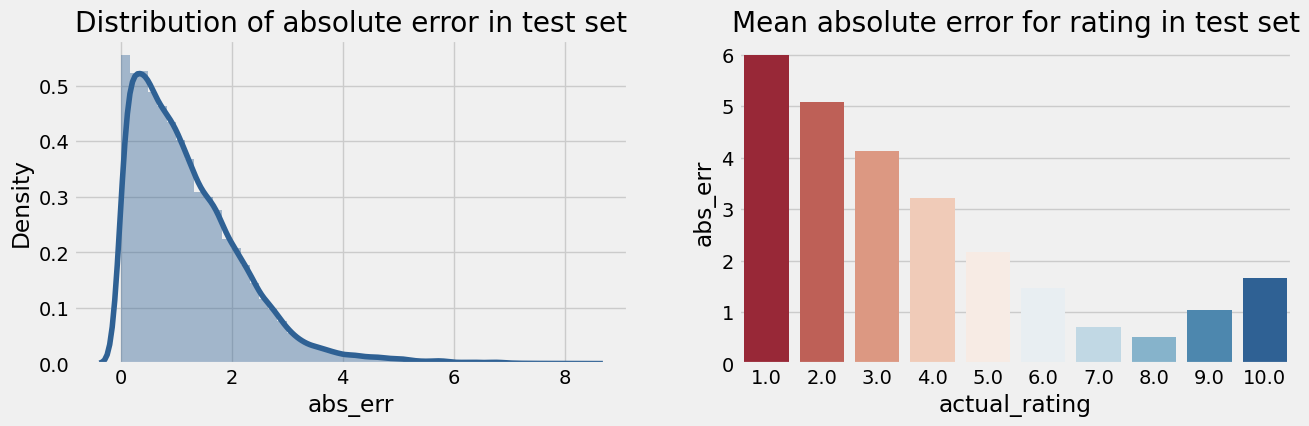

In [189]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

Analysis of predicted ratings of a particular user For this part of the analysis, the user with id 193458 was selected. By analyzing book ratings by this user, it can be noted that he/she likes diverse types of readings: English romantic novels (Pride and Prejudice, Sense and Sensibility), fantasy (Narnia) as well as historical novels (Schindler's List). Among the recommended books there are other works from Narnia's series, two historical novels and one romance which correlates with user's previous preferences.

#Train set: Top rated books

In [190]:
df_books = books.copy()
df_books.rename(columns = {'ISBN':'isbn' ,'Book-Title':'book_title'},inplace=True)
df_ext = df.merge(df_books[['isbn', 'book_title']], on='isbn', how='left')
df_ext = df_ext.merge(df_pred[['isbn', 'user_id', 'pred_rating']], on=['isbn', 'user_id'], how='left')

In [191]:
selected_user_id = 193458
df_user = df_ext[df_ext['user_id']==selected_user_id]

df_user[(df_user['pred_rating'].isna())&(df_user['book_rating']>=9)].sample(10)

,user_id,isbn,book_rating,book_title,pred_rating
113624,193458,014011369X,9,"And the Band Played on: Politics, People, and the AIDS Epidemic",NaN
113628,193458,0142001740,9,The Secret Life of Bees,NaN
113626,193458,0140620125,9,Wuthering Heights (Penguin Popular Classics),NaN
113670,193458,1853260002,10,Pride &amp; Prejudice (Wordsworth Classics),NaN
113625,193458,0140298479,9,Bridget Jones: The Edge of Reason,NaN
113622,193458,0064471098,9,The Silver Chair,NaN
113660,193458,0671880314,9,Schindler's List,NaN
113668,193458,0887309100,9,The Dilbert Future: Thriving on Business Stupidity in the 21st Century,NaN
113621,193458,006447108X,9,The Last Battle,NaN
113634,193458,0345342569,9,Shoeless Joe,NaN


#Test set: actual top rated books

In [192]:
# testing our model
df_user[df_user['pred_rating'].notna()].sort_values('pred_rating', ascending=False).head(10)

,user_id,isbn,book_rating,book_title,pred_rating
113623,193458,0064471101,9,The Magician's Nephew (rack) (Narnia),8.467864
113656,193458,0553258001,9,The Cider House Rules,8.415806
113643,193458,0399145923,6,Carolina Moon,8.413873
113673,193458,1853260622,5,War and Peace (Wordsworth Classics),8.178514
113632,193458,0316781010,7,Fortune's Rocks: A Novel,8.152028
113664,193458,0789404257,9,Eyewitness Travel Guide to Italy (revised),8.050563
113637,193458,034536743X,7,The 158-Pound Marriage,7.880320
113669,193458,1575001438,7,Survivor : The Ultimate Game,7.818750
113645,193458,042518109X,7,Whispers,7.785837
113631,193458,0316569321,8,White Oleander : A Novel,7.691187


Above recommended books seems pretty much related.

So our first recommender engine is finished.

#4.Content Based
This system recommends books by calculating similarities in Book Titles. For this, TF-IDF feature vectors were created for unigrams and bigrams of Book-Titles; only those books' data has been considered which are having at least 80 ratings.

In [193]:
#seting thershold as 80
popularity_threshold = 80
# sort the result based on thershgold value
popular_book = result[result['Total-Rating'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
#print the shape of popular books
popular_book.shape

(44652, 12)

In [194]:
#using TF vectorizer function
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
#fit the Tf vectoriser model
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(44652, 1112)

In [195]:
# normalising the df
normalized_df = tfidf_matrix.astype(np.float32)
#checking for cosine similarity
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
#checking the shape
cosine_similarities.shape

(44652, 44652)

In [196]:
print("Recommended Books:\n")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:

Harry Potter and the Sorcerer's Stone (Book 1)


#5. Hybrid Approach (Content+Collaborative) Using percentile
A hybrid recommendation system was built using the combination of both content-based filtering and collaborative filtering systems. A percentile score is given to the results obtained from both content and collaborative filtering models and is combined to recommend top n books.

In [197]:
#creating a list
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
#checking for recomendation using collebrative filtering
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

#using content based filtering to check the recomendations
for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]
# take common from both recomendation systems
# store in a dict
ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
print("Input Book:\n")
#print the input book name
print(bookName)
#print the recomenmned books
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Input Book:

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Recommended Books:

Harry Potter and the Prisoner of Azkaban (Book 3)


#Conclusion:

● Recommendation system is unturned to exist in the e-commerce businesses with the help of collaborative or content-based filtering to predict different items and yes, users are most satisfied with the products recommended to them.

● While performing Exploratory Data Analysis we observed that almost 42% of readers with age-34 read more books compared to other age group of readers.

● Books with publication years are somewhat between 1950 - 2005.

● Also the readers mostly give 8 ratings(on scale 1-10) to books followed by 10 and 7.

● There are more readers from locations London,england,united kingdom,toronto,ontario,canda cmpare to other locations.

● KNN model gives good recommendation for books.

● SVD(Singular value decompostion) with best accuracy on test data which give stronger recommendations.These results show that our proposed system can remove boring

books from the recommendation list more efficiently.

● Popularity based recommendation systems helpful to new users. we don't have data about new user so here popularity based recommendations are more useful

● Content based recommendation systems aslo perfoming well , they are give more accurate predictions.

● A hybrid recommendation system was built using the combination of both content-based filtering and collaborative filtering systems. A percentile score is given to the results obtained from both content and collaborative filtering models and is combined

● Most of the companies like Netflix , Amazon are using Hybrid recommendation search engines ,becuse they are more efficient..

● In Our case also Hybrid approch gives best recommendations...

● Finally this was nice Project to Work .I think i build a most efficient recommendation system